# Working with irregular timestamps


Some datasets have irregular time frequencies of the observations. These datasets
come with some extra challenges. Here is some information on how to deal with them.

A common problem that can arise is that most observations are **not present** and
that **a lot of missing observations** (and gaps) are introduced. This is because
the toolkit assumes that each station has observations at a constant frequency. So the toolkit expects
a perfectly regular timestamp series. The toolkit will hence ignore observations
that are not on the frequency, so observations get lost. Also, it looks for observations
on perfectly regular time intervals, so when a timestamp is not present, it is assumed to be missing.


To avoid these problems you can **synchronize** your observations. Synchronizing will
convert your irregular dataset **to a regular dataset** and an **easy origin** is chosen if possible.
(The origin is the first timestamp of your dataset.) Converting your dataset to a regular dataset is performed
by shifting the timestamp of an observation. For example, if a frequency of 5 minutes is assumed and the observation
has a timestamp at 54 minutes and 47 seconds, the timestamp is shifted to 55 minutes. A certain
maximal threshold needs to be set to avoid observations being shifted too much. This threshold is
called the tolerance and it indicates what the **maximal time-translation** error can be for one
observation timestamp.


Synchronizing your observations can be performed with the :py:meth:`sync_observations()<metobs_toolkit.dataset.Dataset.sync_observations>`
method. As an argument of this function, you must provide a tolerance.


## Example

In this example, we use a small dataset with three stations that have irregular and unsynchronized timestamps. The dataset can be found [here](https://github.com/vergauwenthomas/MetObs_toolkit/blob/master/tests/test_data/wide_test_data.csv) and the template file can be found [here](https://github.com/vergauwenthomas/MetObs_toolkit/blob/master/tests/test_data/wide_test_template.json).


In [1]:
import pandas as pd
datafile = 'https://raw.githubusercontent.com/vergauwenthomas/MetObs_toolkit/master/tests/test_data/wide_test_data.csv'
templatefile = 'https://raw.githubusercontent.com/vergauwenthomas/MetObs_toolkit/master/tests/test_data/wide_test_template.json'


# As an example, here is how the data looks like
df =pd.read_csv(datafile)
df

,Tijd,MolenhofWeer - Temperatuur (°C),QuattroCoronati - Temperatuur (°C),Vlinder 02 Gent - Temperatuur (°C)
0,2023-04-17 16:58:40,14.0,NaN,NaN
1,2023-04-17 16:59:01,NaN,14.6,NaN
2,2023-04-17 17:57:41,NaN,14.3,NaN
3,2023-04-17 17:57:54,15.3,NaN,NaN
4,2023-04-17 18:56:31,NaN,14.0,NaN
...,...,...,...,...
194,2023-04-21 15:57:04,NaN,17.5,NaN
195,2023-04-21 15:58:47,17.1,NaN,NaN
196,2023-04-21 16:06:00,NaN,NaN,16.5
197,2023-04-21 16:07:44,NaN,17.2,NaN


It can clearly be seen that timestamps are not synchronized over the stations and that the time resolution is not perfect for the stations. We can fix these timestamps in the toolkit when we import the datafile.

When a datafile is imported, the toolkit will convert the time series to "perfect" timestamps (= equally spaced timestamps). To do this, the toolkit must estimate the **frequency** (=time resolution) for each station. In addition, the toolkit will estimate an **origin** and a **last timestamp** for each station. Once these three parameters (freq, origin, and last timestamp) are computed, a perfect time series is created. At last, the toolkit will map the records in the datafile to these perfect timestamps. 

When the timestamps in the datafile are irregular, we can fix them by specifying tolerances and simplifications for mapping to perfect timestamps when importing the data from file: ``Dataset.import_data_from_file()``

In [2]:
import metobs_toolkit

dataset = metobs_toolkit.Dataset()
dataset.update_file_paths(
    input_data_file=datafile,
    template_file=templatefile)


dataset.import_data_from_file(
        freq_estimation_method="highest", #highest or median
        freq_estimation_simplify_tolerance="2min", #Try to simplify the frequency, the maximum simplification tolerance is 2 minutes
        origin_simplify_tolerance="5min", #try to simplify the origin, the maximum simplification tolerance is 5 minutes
        timestamp_tolerance="4min", #The maximum tolerance for mapping records to perfect timestamps is 5 minutes
        templatefile_is_url=True)

The following data columns are renamed because of special meaning by the toolkit: {}


No metadata file is defined,                    no metadata attributes can be set!


These stations will be removed because of only having one record: []


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/df_helpers.py:54: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  return pd.concat([df.dropna(axis=1, how="all") for df in df_list], **kwargs)


The freqency, origin and latest timestamp are stored per station in the `Dataset.metadf` in the `dataset_resolution`, `dt_start` and `dt_end` columns:

In [3]:
dataset.metadf

,lat,lon,geometry,dataset_resolution,dt_start,dt_end
name,,,,,,
MolenhofWeer - Temperatuur (°C),NaN,NaN,NaN,0 days 00:01:00,2023-04-17 17:00:00+02:00,2023-04-21 16:09:00+02:00
QuattroCoronati - Temperatuur (°C),NaN,NaN,NaN,0 days 00:01:00,2023-04-17 17:00:00+02:00,2023-04-21 16:09:00+02:00
Vlinder 02 Gent - Temperatuur (°C),NaN,NaN,NaN,0 days 00:01:00,2023-04-17 17:00:00+02:00,2023-04-21 16:09:00+02:00


Because of the wide-structured data, the toolkit assumes a 1-minute-frequency. What we can do is to coarsen the time resolution to hourly. 

**Note**: to avoid propagation of errors and tolerances, it is best to shift timestamps only once. For this example, this can be done by importing the data without simplifications or tolerances and coarsening it with tolerances.

**Note**: In this wide datafile example, the toolkit interprets the timestamps without a value as gaps, and is the assumption of 1-minute-frequency the correct one. This issue is typically related to wide-structured-datasets.

A 0 days 00:00:00 is given as an argument for a timedelta.


A 0 days 00:00:00 is given as an argument for a timedelta.


A 0 days 00:00:00 is given as an argument for a timedelta.


The following data columns are renamed because of special meaning by the toolkit: {}


No metadata file is defined,                    no metadata attributes can be set!


These stations will be removed because of only having one record: []


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/df_helpers.py:54: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  return pd.concat([df.dropna(axis=1, how="all") for df in df_list], **kwargs)


A 0 days 00:00:00 is given as an argument for a timedelta.


<Axes: title={'center': 'None for all stations. '}, ylabel='temp (Celsius)'>

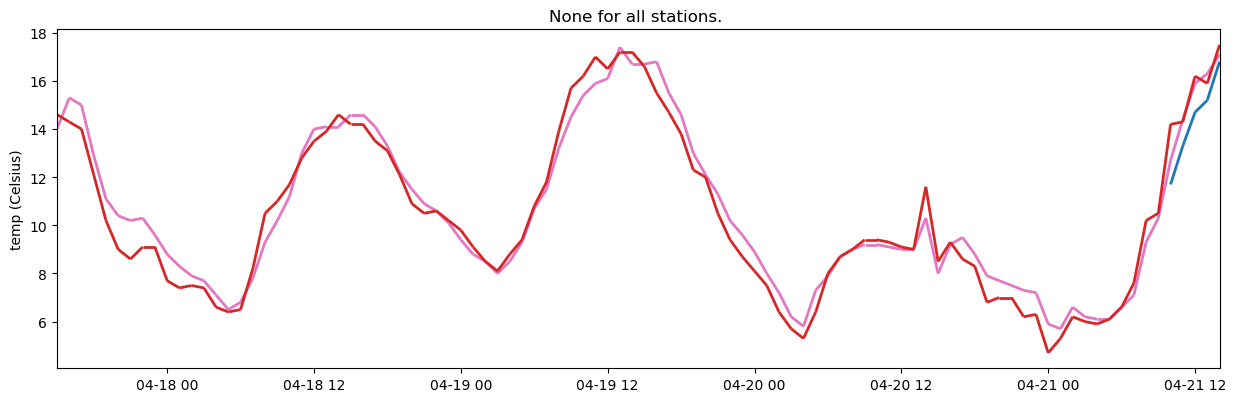

In [4]:

import datetime

#import without simplifications and tolerances (to avoid error propagation/cumulation)
dataset.import_data_from_file(
        freq_estimation_method="highest", #highest or median
        freq_estimation_simplify_tolerance="0min", #Try to simplify the frequency, the maximum simplification tolerance is 2 minutes
        origin_simplify_tolerance="0min", #try to simplify the origin, the maximum simplification tolerance is 5 minutes
        timestamp_tolerance="0min", #The maximum tolerance for mapping records to perfect timestamps is 5 minutes
        templatefile_is_url=True)

dataset.sync_records(
        timestamp_shift_tolerance="6min",
         freq_shift_tolerance="0min",
         fixed_origin=None,
         fixed_enddt=None,
         fixed_freq='1h',
         direction="nearest",)

dataset.make_plot()

We can see that the timestamps in the Dataset are "perfect", and that the stations are synchronized. 

In [5]:
dataset.get_full_status_df()['temp']['value'].unstack().transpose()


name,MolenhofWeer - Temperatuur (°C),QuattroCoronati - Temperatuur (°C),Vlinder 02 Gent - Temperatuur (°C)
datetime,,,
2023-04-17 17:00:00+02:00,14.0,14.6,NaN
2023-04-17 18:00:00+02:00,15.3,14.3,NaN
2023-04-17 19:00:00+02:00,15.0,14.0,NaN
2023-04-17 20:00:00+02:00,12.9,12.1,NaN
2023-04-17 21:00:00+02:00,11.1,10.2,NaN
...,...,...,...
2023-04-21 12:00:00+02:00,12.7,14.2,11.7
2023-04-21 13:00:00+02:00,14.4,14.3,13.3
2023-04-21 14:00:00+02:00,15.9,16.2,14.7
